<a href="https://colab.research.google.com/github/efratrvd/tel-aviv-rent-analysis/blob/main/Tel_Aviv_Rental_Market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
! pip install geopandas

In [ ]:
import json
from more_itertools import first
from collections import Counter

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

from shapely.geometry import Point, Polygon
from shapely import wkt
import geopandas

import matplotlib.pyplot as plt
import seaborn as sns

import folium
from folium.plugins import HeatMap

from wordcloud import WordCloud, STOPWORDS

In [ ]:
!mkdir /root/.kaggle/

api_token = {'username':'<USER-NAME>', 'key':'<API-KEY>'}

with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download doit-intl/tel-aviv-neighborhood-polygons
!unzip *.zip

  0% 0.00/68.6k [00:00<?, ?B/s]
100% 68.6k/68.6k [00:00<00:00, 29.5MB/s]
Archive:  tel-aviv-neighborhood-polygons.zip
  inflating: tel_aviv_neighborhood.csv  


## Tel-Aviv Rental Prices

We use a dataset containing properties for rent in Tel-Aviv that were in the market between May 2021 and August 2021. The data contains details about each property like the rental price, size in meters, number of rooms, location and more.

In [ ]:
properties = pd.read_csv('./gdrive/MyDrive/ta-rent/properties.csv')
print(properties.shape)

## we drop properties that have missing values as they are not comparable.  
## We allow a missing value for the street number
properties.dropna(subset=['address.street', 'squareMeters', 'rentPrice', 'areas', 'floor', 'coords.lat', 'coords.lng', 'numOfRooms'],
                  axis=0,
                  inplace=True)
properties.shape

(5000, 16)


(4044, 16)

In [ ]:
## removing outliers, probably wrong entries in the data
## these could be properties that are for sell, parking spots, storage places and more
properties = properties[(properties['rentPrice'] <= 100000) & 
                        (properties['rentPrice'] >= 2000) & 
                        (properties['squareMeters'] <= 600) &
                        (properties['squareMeters'] >= 15)].reset_index(drop=True)
properties.shape

(3963, 16)

In [ ]:
properties.head()

,_id,address.houseNumber,address.street,areas,coords.lat,coords.lng,floor,hasBalcony,hasElevator,hasGarden,isBroker,isRenovated,numOfRooms,parking,rentPrice,squareMeters
0,5a18221e6f1499db35c8d903,5.0,אמיר גלבוע,"[""עבר הירקון מערב"",""הגוש הגדול, רמת אביב החדשה...",32.116148,34.788060,0.0,False,YES,True,True,NO,5.0,1.0,20000.0,413.0
1,5b55f4a6dd219e0014b5b910,NaN,יפת,"[""יפו"",""עגמי, גבעת העליה"",""עגמי"",""תל אביב יפו""...",32.043848,34.751912,2.0,True,YES,False,True,YES,3.0,0.0,7000.0,70.0
2,5b55ed0d91b0f20014d8f6be,NaN,"רנ""ק","[""צפון ישן"",""הצפון הישן - צפון"",""ארלוזורוב"",""ב...",32.086193,34.773593,2.0,True,NO,False,True,YES,3.0,0.0,8700.0,75.0
3,5b55eca691b0f20014d8f55d,NaN,הנשיאים,"[""צפון חדש"",""בבלי"",""תל אביב יפו"",""מרכז הארץ""]",32.091626,34.797423,5.0,True,YES,False,True,YES,4.0,1.0,7400.0,100.0
4,5b55e9f6dd219e0014b5a34a,NaN,משה פרלוק,"[""עבר הירקון מערב"",""הגוש הגדול, רמת אביב החדשה...",32.115056,34.791650,4.0,True,YES,False,True,YES,5.0,1.0,9200.0,135.0


### Tel-Aviv in general

We start with some EDA of the properties in the dataset. We aim to identify different factors that affect the rental price in Tel-Aviv and provide insights to Tel-Aviv's rental market.

Below you can see the spread of the properties in the dataset around the city. Our data contains properties from all of Tel-Aviv's neighborhoods and areas, implying it is representative of the Tel-Aviv rental market.

There is a large concentration of apartments in the heart of the city with less apartments in the perimeters. This reflects the fact that the city center is more crowded and charachterized by dense construction.

In [ ]:
property_locations = [(lat, long) for (lat, long) in properties[['coords.lat', 'coords.lng']].values]

map = folium.Map(location=[32.0853, 34.7818], zoom_start=12, tiles = 'Stamen Terrain')
HeatMap(property_locations, radius = 20).add_to(map)
display(map)

The following graph presents the distribution of rental prices. The price is in NIS and is for a month of rent. The distribution is right skewed, with a mean of 8032 NIS and a std of 3845 NIS. 

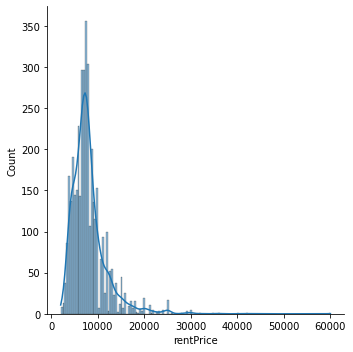

In [ ]:
sns.displot(data=properties, x='rentPrice', kde=True)
plt.show()

In [ ]:
properties[['rentPrice']].describe()

,rentPrice
count,3963.000000
mean,8032.071411
std,3845.317396
min,2000.000000
25%,5800.000000
50%,7500.000000
75%,9000.000000
max,60000.000000


The rent price is naturally affected by the property size in terms of number of rooms. The following graph presents the distribution of properties per number of rooms. 

This distribution teaches us about the population in tel-aviv as well. Most properties for rent are 3 room apartments, meaning apartments fit for small families, couples or roommates. There is a very small portion of properties with over 5 rooms,

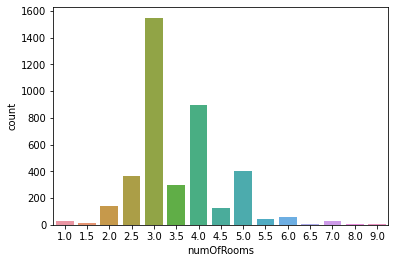

In [ ]:
sns.countplot(data=properties, x='numOfRooms')
plt.show()

For simplicity we bin the number of rooms. We show the average rent price and a confidence interval for each apartment size. Based on the graph, renting an average 3 room apartment in Tel-Aviv will cost around 6500 NIS a month.

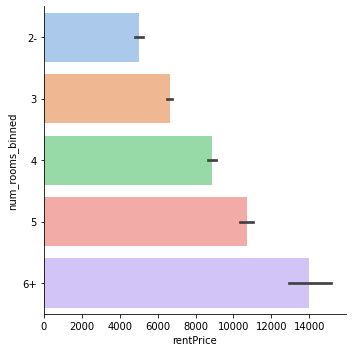

In [ ]:
## The number of rooms is rounded, meaning half-rooms are considered as a full room
properties['num_rooms_binned'] = pd.cut(properties['numOfRooms'].values,
                                        bins=[0, 2, 3, 4, 5, 10],
                                        labels=['2-', '3', '4', '5', '6+'])

sns.catplot(data=properties,
            x='rentPrice', y='num_rooms_binned',
            kind='bar',
            palette='pastel')
plt.show()

The rent price is also naturally affected by the property size in squared meters. The following graph presents the distribution of properties per size. The distribution shows that Tel-Aviv properties tend to be pretty large, with most properties around 100 square meters. This property is different than other large cities in the world known for their small properties, like New York and Paris.

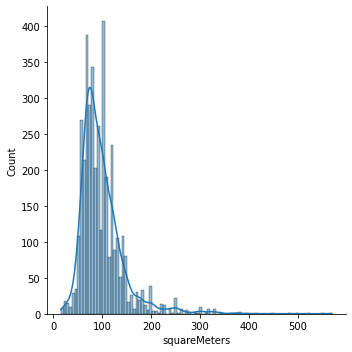

In [ ]:
sns.displot(data=properties, x='squareMeters', kde=True)
plt.show()

The following graph presents the property size distribution by number of rooms in the apartment. 

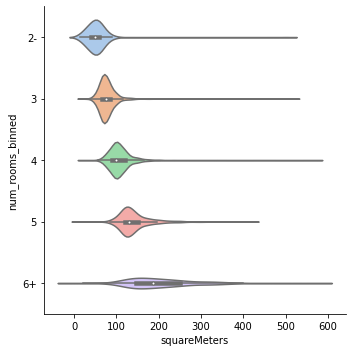

In [ ]:
sns.catplot(data=properties,
            x='squareMeters', y='num_rooms_binned',
            kind='violin',
            palette='pastel')
plt.show()

### Tel-Aviv by neighborhoods

In addition, we analyze the differences between the neighborhoods in Tel-Aviv.

We use a geographical dataset from kaggle containing the polygons for each of Tel-Aviv's neighborhoods. 

In [ ]:
def load_and_close_polygon(wkt_text):
    poly = wkt.loads(wkt_text)
    point_list = poly.exterior.coords[:]
    point_list.append(point_list[0])
    
    return Polygon(point_list)

neighborhoods_df = geopandas.read_file('tel_aviv_neighborhood.csv')
neighborhoods_df['geometry'] = neighborhoods_df['area_polygon'].apply(load_and_close_polygon)
neighborhoods_df.head()

,oid_shchuna,neighborhood_id,neighborhood_name,date_import,Shape_Area,area_polygon,geometry
0,1,3,Sde Dov area,2015-10-06 08:36:43 UTC,1307955.33559649,"POLYGON ((34.788389 32.123656, 34.788383 32.12...","POLYGON ((34.78839 32.12366, 34.78838 32.12364..."
1,2,2,Spring Cliffs,2015-10-06 08:36:43 UTC,1288924.75437951,"POLYGON ((34.796243 32.130388, 34.795859 32.12...","POLYGON ((34.79624 32.13039, 34.79586 32.12870..."
2,3,7,Ramat Aviv c,2015-10-06 08:36:43 UTC,1101581.53746348,"POLYGON ((34.808554 32.128712, 34.808641 32.12...","POLYGON ((34.80855 32.12871, 34.80864 32.12863..."
3,4,11,Tel aviv university,2015-10-06 08:36:43 UTC,1459851.23377099,"POLYGON ((34.802354 32.118062, 34.80239 32.118...","POLYGON ((34.80235 32.11806, 34.80239 32.11806..."
4,5,6,North Star,2015-10-06 08:36:43 UTC,421229.757424996,"POLYGON ((34.783522 32.098636, 34.783493 32.09...","POLYGON ((34.78352 32.09864, 34.78349 32.09864..."


In [ ]:
## add neighborhood to each property
polygon_to_neighborhood = neighborhoods_df.set_index('neighborhood_name')['geometry'].to_dict()

def get_neighborhood_name(row):
  lat, long = row
  point = Point(long, lat)
  return first((neigh for neigh, poly in polygon_to_neighborhood.items() if poly.contains(point)), default=None)

properties['neighborhood'] = properties[['coords.lat', 'coords.lng']].apply(get_neighborhood_name, axis=1)

Below you may see boxplots for the rent prices in Tel-Aviv's neighborhoods. It is easy to spot the expensive neighborhoods, like Neve Tzedek, Ajami and Tel Baruch. 

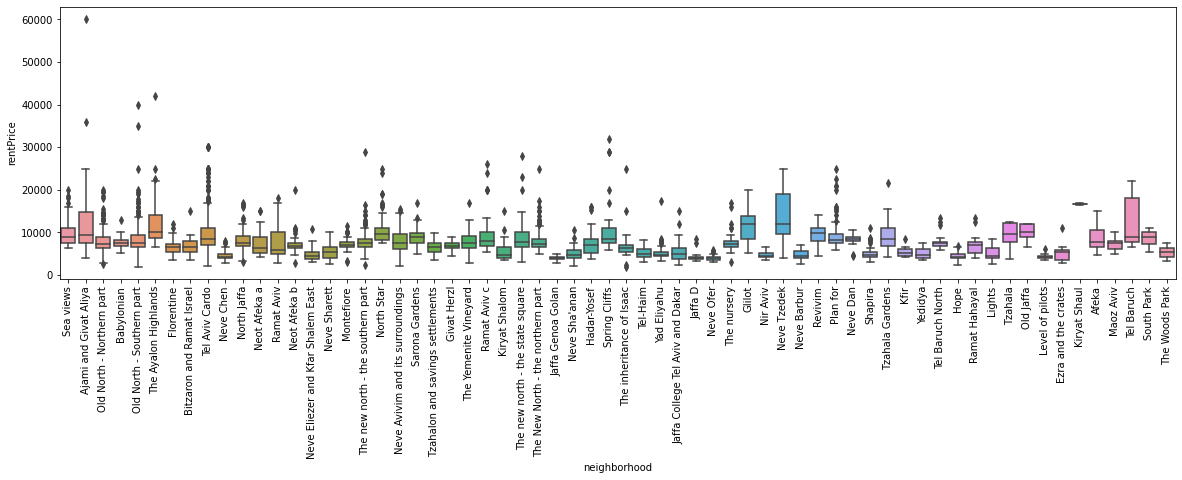

In [ ]:
plt.figure(figsize=(20,5))
ax = sns.boxplot(data=properties, x='neighborhood', y='rentPrice')
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
plt.show()

The following graph focuses on the top 15 neighborhoods by number of properties for rent.

In [ ]:
neighborhood_counts = properties.groupby('neighborhood')[['address.street']].count()
top_neighborhoods = neighborhood_counts.sort_values('address.street', ascending=False).head(15)
top_neighborhoods

,address.street
neighborhood,
Tel Aviv Cardo,447
Old North - Northern part,283
Old North - Southern part,259
Sea views,155
The new north - the state square,141
The new north - the southern part,127
Neve Sharett,120
The Ayalon Highlands,118
Ramat Aviv c,112


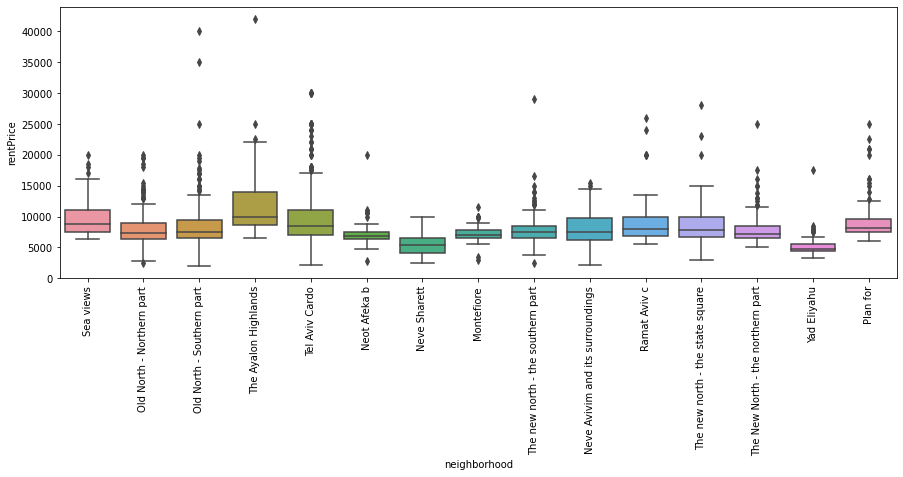

In [ ]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(data=properties[properties['neighborhood'].isin(top_neighborhoods.index)],
                 x='neighborhood',
                 y='rentPrice')
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
plt.show()

**Average rent price of Tel Aviv neighborhoods**

In addition, we plot the average rent price by neighborhood on a map of the city. The map shows clearly that the southern neighborhoods of the city are the cheapest. As you go north, the properties are more expensive. The average rent prices differ between northern and southern neighborhoods by approximately 4000 NIS.

There are some neighborhoods that stand out in their area, like Neve-Tzedek, Ajami and Tel Baruch which are neighborhoods much more expensive than their environment. 

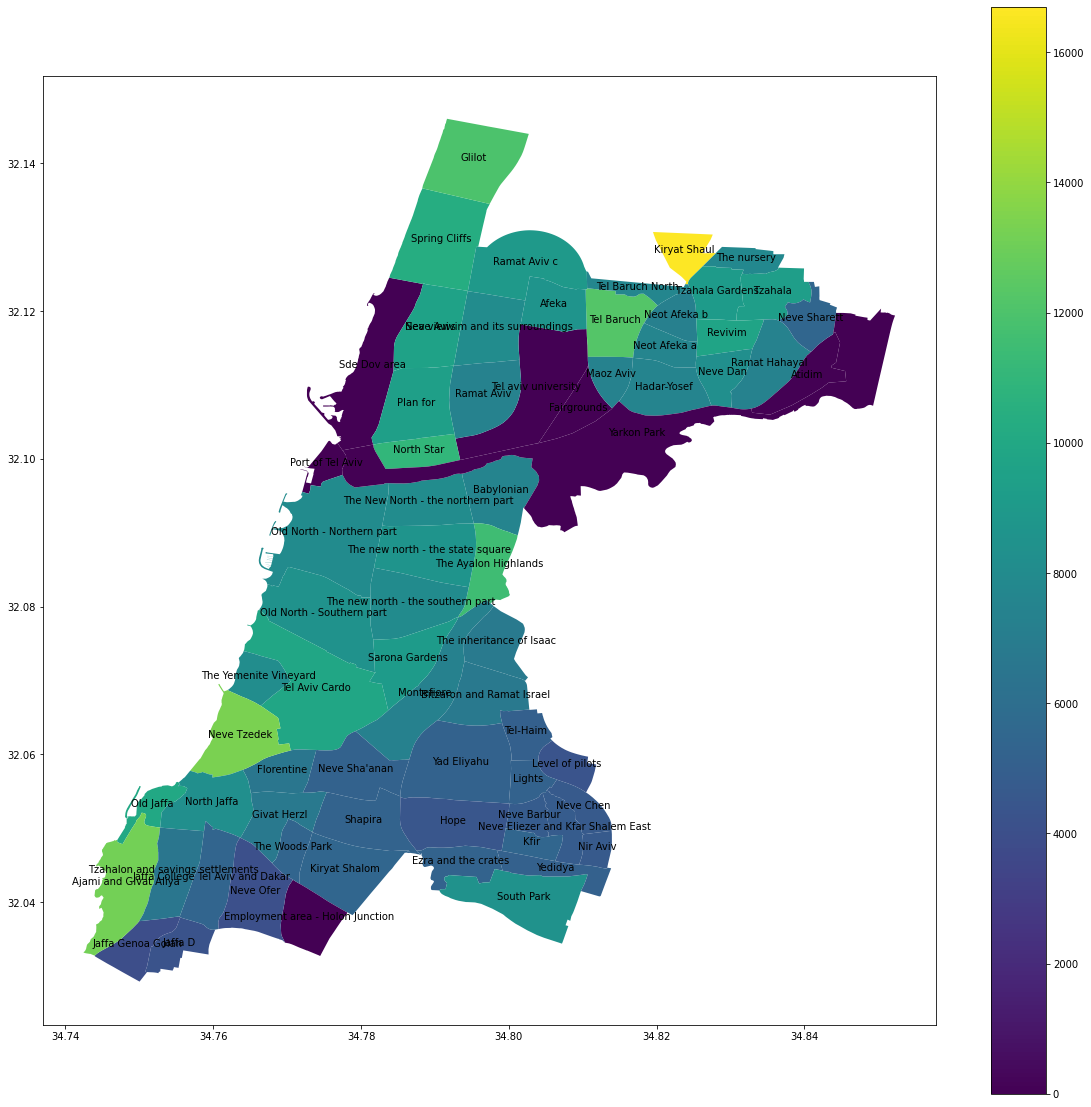

In [ ]:
mean_rent_in_neighborhood = properties.groupby('neighborhood')['rentPrice'].mean()
neighborhoods_df['average_rent'] = neighborhoods_df['neighborhood_name'].map(mean_rent_in_neighborhood)
neighborhoods_df.fillna(0, inplace=True) ## areas that aren't residential, like parks, the university and the port

ax = neighborhoods_df.plot(figsize=(20,20), column="average_rent", legend=True)
neighborhoods_df.apply(lambda x: ax.annotate(s=x['neighborhood_name'],
                                             xy=x.geometry.centroid.coords[0],
                                             ha='center'),
                       axis=1)
plt.show()

As we stated above, the rent price is naturally explained among other reasons by the property size. The following graph shows the distributions of property sizes in terms of number of rooms for each neighborhood. The graph shows that the northern neighborhoods do tend to have larger apartments than the southern neighborhoods, explaining a part of the large difference in the average rent prices.

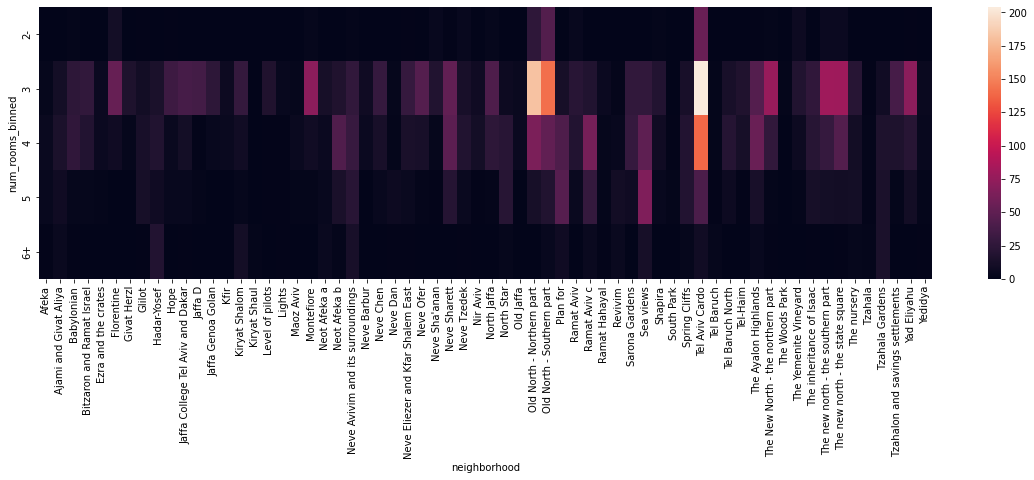

In [ ]:
plt.figure(figsize=(20,5))
property_sizes_by_neighborhood = pd.pivot_table(properties, columns='neighborhood', index='num_rooms_binned', values='address.street', aggfunc='count').fillna(0)
sns.heatmap(property_sizes_by_neighborhood)

The above analysis highlights the differences between the neighborhoods in Tel-Aviv in terms of the rental price. We would like to investigate if the high rental prices buy you quality of life, meaning are the more expensive neighborhoods also "better".

To do so we use [Google Maps' Places API](https://developers.google.com/maps/documentation/places/web-service). For each property, we query for the top 20 places within a 300 meter radius ranked by prominance as defined by Google's algorithms. More information on the ranking algorithm can be found [here](https://developers.google.com/maps/documentation/places/web-service/search-nearby). 

To quantify how "good" a neighborhood is we calculate the average rating of the places that surfaced from the search above. The ratings are a score calculated based on people's comments and ratings for each place, meaning they are based on crowd wisdom and not an algorithm.   

In [ ]:
nearby_places = pd.read_csv('./gdrive/MyDrive/ta-rent/property_nearby_places_df.csv',
                            converters={'places_name': eval, 'places_rating': eval,'places_types': eval,'places_num_rating': eval})
properties = properties.merge(nearby_places, on='_id')

In [ ]:
def get_rating_avg(x):
  ratings = [r for r in x if r is not None]
  return np.mean(ratings).astype(float)

properties['place_avg_rating'] = properties['places_rating'].apply(get_rating_avg)

In [ ]:
mean_rating_in_neighborhood = properties.groupby('neighborhood')['place_avg_rating'].mean()
neighborhoods_df['average_rating'] = neighborhoods_df['neighborhood_name'].map(mean_rating_in_neighborhood)

**Average rating for the most prominent places in each neighborhood**

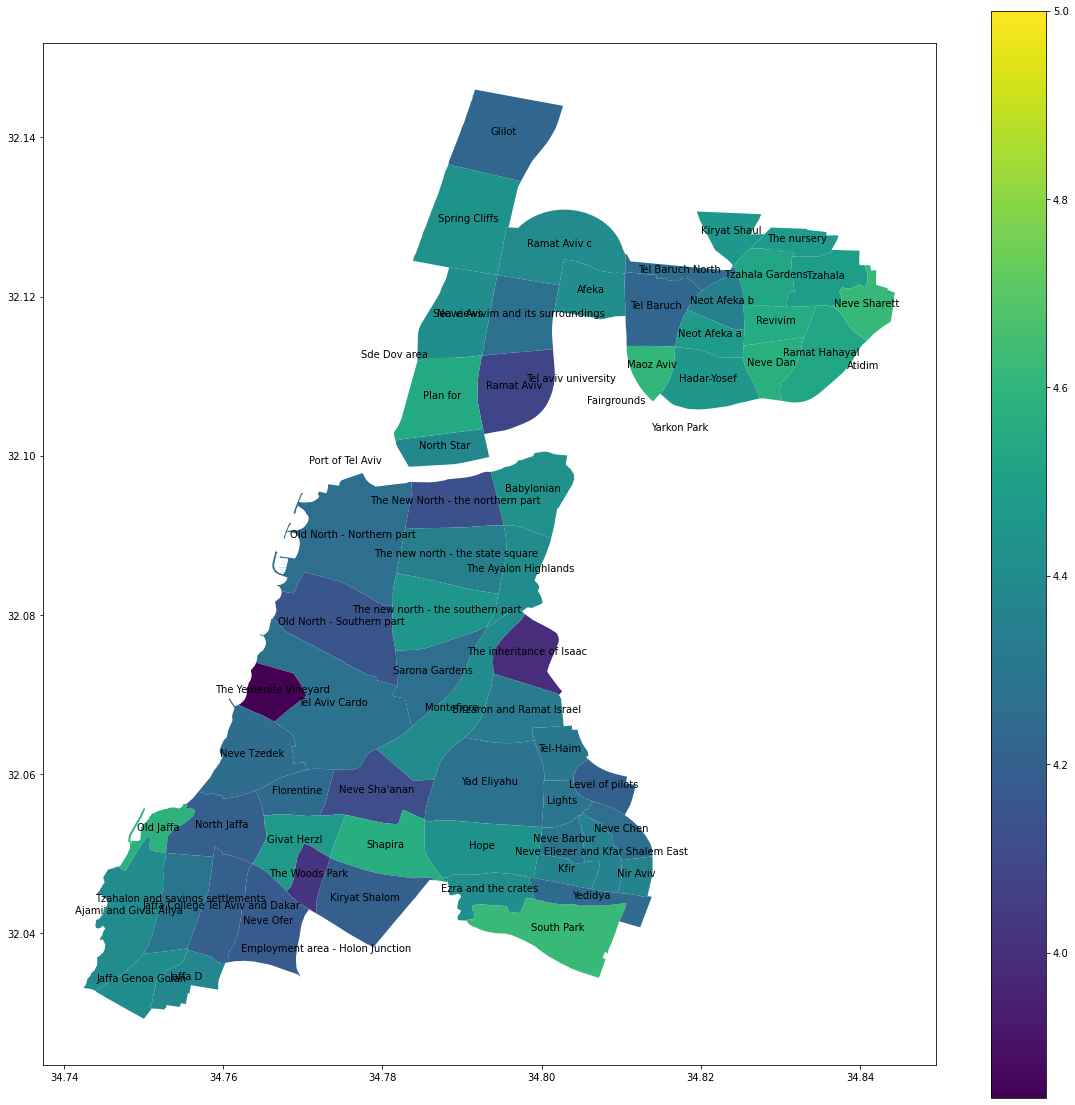

In [ ]:
ax = neighborhoods_df.plot(figsize=(20,20), column='average_rating', legend=True, vmax=5)
neighborhoods_df.apply(lambda x: ax.annotate(s=x['neighborhood_name'],
                                             xy=x.geometry.centroid.coords[0],
                                             ha='center'),
                       axis=1)
plt.show()

In the map above we can see the average rating for the most prominent places in each neighborhood. The map shows that places in the northern neighborhoods of Tel-Aviv are rated higher than places in the southern neighborhoods and in the city center. 

Though Tel Baruch neighborhood in the north is expensive compared to its area, the properties in the neighborhood are rated lower than the other neighborhoods in its area. 
In addition, Shapira neighborhood stands out in its high ratings compared to its area without being more expensive.

In addition, we analyze if there is a difference in the most prominent places between cheep and expensive neighborhoods. To do so we split the neighborhoods to 3 groups based on the average rent price. We analyze the types of the prominent places in the neighborhood, meaning what type of establishments are common in each group.

In [ ]:
def get_type_list(x):
  all_places = [item for sublist in x for item in sublist]
  return [place for place in all_places if place not in ["neighborhood", "point_of_interest", "establishment", "health"]]

properties['places_types_flatten'] = properties['places_types'].apply(get_type_list)

In [ ]:
place_types_in_neighborhood = properties.groupby('neighborhood')['places_types_flatten'].apply(lambda x: x.sum())
neighborhoods_df['place_types'] = neighborhoods_df['neighborhood_name'].map(place_types_in_neighborhood)

In [ ]:
high_rent_n = neighborhoods_df[neighborhoods_df['average_rent'] >= 10000]
mid_rent_n = neighborhoods_df[(neighborhoods_df['average_rent'] < 10000) & (neighborhoods_df['average_rent'] >= 5000)]
low_rent_n = neighborhoods_df[neighborhoods_df['average_rent'] < 5000]

In [ ]:
high_rent_types_list = [item for sublist in list(high_rent_n['place_types']) for item in sublist]
mid_rent_types_list = [item for sublist in list(mid_rent_n['place_types']) for item in sublist]
low_rent_types_list = [item for sublist in list(low_rent_n['place_types']) for item in (sublist if type(sublist) == list else [])]

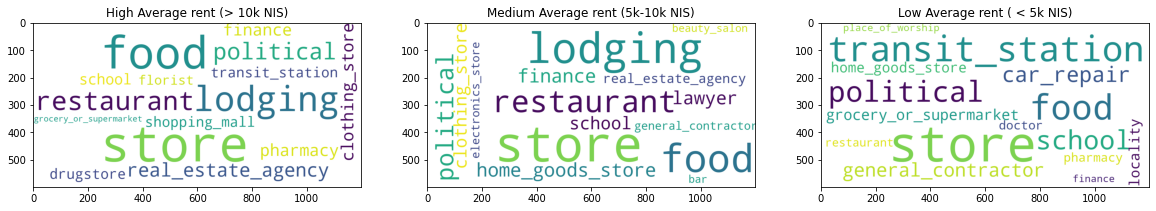

In [ ]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=15,
        max_font_size=60, 
        scale=3,
        collocations=False,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(" ".join(data))
    return wordcloud

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize=(20, 20))
ax1.imshow(show_wordcloud(high_rent_types_list))
ax1.set_title("High Average rent (> 10k NIS)")
ax2.imshow(show_wordcloud(mid_rent_types_list))
ax2.set_title("Medium Average rent (5k-10k NIS)")
ax3.imshow(show_wordcloud(low_rent_types_list))
ax3.set_title("Low Average rent ( < 5k NIS)")

fig.show()

The word clouds above show the most commmon prominent establishments in each group of neighborhoods. 

The word cloud based on the neighborhoods with a low average rent is different than the word clouds of the neighborhoods with high average rent and medium rent, with prominent transit stations, car repair sights and places of worship. These types of establishments aren't prominent in the medium and high rent neighborhoods. 

The medium and high rent neighborhoods are more similar in the prominent establishments, containing restaurants, lodging, financial institutes and more. 


## Predicting & Explaining Rent Prices

In order to predict rental prices in Tel-Aviv, we fit a linear regression model to the data.

In [ ]:
x_columns = ['coords.lat',
            'coords.lng',
            'floor',
            'hasBalcony',
            'hasElevator',
            'hasGarden',
            'isBroker',
            'isRenovated',
            'numOfRooms',
            'parking',
            'squareMeters']
y_val = 'rentPrice'

In [ ]:
## preprocess data, change to indicators
def convert_columns_to_numerical(val):
  if val == 'YES':
    return 1
  return 0

properties.fillna({col: 0 for col in x_columns}, inplace=True)
properties['hasBalcony'] = properties['hasBalcony'].astype(int)
properties['hasGarden'] = properties['hasGarden'].astype(int)
properties['isBroker'] = properties['isBroker'].astype(int)
properties['hasElevator'] = properties['hasElevator'].apply(convert_columns_to_numerical)
properties['isRenovated'] = properties['isRenovated'].apply(convert_columns_to_numerical)

In [ ]:
properties[x_columns]

,coords.lat,coords.lng,floor,hasBalcony,hasElevator,hasGarden,isBroker,isRenovated,numOfRooms,parking,squareMeters
0,32.116148,34.788060,0.0,0,1,1,1,0,5.0,1.0,413.0
1,32.043848,34.751912,2.0,1,1,0,1,1,3.0,0.0,70.0
2,32.086193,34.773593,2.0,1,0,0,1,1,3.0,0.0,75.0
3,32.091626,34.797423,5.0,1,1,0,1,1,4.0,1.0,100.0
4,32.115056,34.791650,4.0,1,1,0,1,1,5.0,1.0,135.0
...,...,...,...,...,...,...,...,...,...,...,...
3958,32.076736,34.770016,2.0,1,1,0,1,1,2.5,1.0,80.0
3959,32.084301,34.772136,6.0,1,1,0,1,1,4.5,1.0,120.0
3960,32.123183,34.814590,3.0,1,1,0,0,1,5.0,1.0,120.0
3961,32.085476,34.793505,1.0,0,0,0,0,0,3.5,0.0,75.0


We run a 5-fold cross validation for the model, measuring the negated RMSE score for the model on the test set in each fit.

In [ ]:
lr_model = LinearRegression()
scores = cross_val_score(lr_model,
                         properties[x_columns],
                         properties['rentPrice'],
                         scoring='neg_root_mean_squared_error')
scores.mean()

-2576.264165385414

The RMSE shows that the prediction error for the model is around 2500 NIS, which is pretty high. We wouldn't expect a linear model to be a good predictor for rental prices as it's a complex predictions problem.

With that been said, we will use the coefficients of the model to explain the different parameters that affect the rental prices.

We refit the model on all the data

In [ ]:
X_mat = sm.add_constant(properties[x_columns])
lr_model = sm.OLS(properties['rentPrice'], X_mat).fit()
lr_model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              rentPrice   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     437.4
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        20:35:15   Log-Likelihood:                -36758.
No. Observations:                3963   AIC:                         7.354e+04
Df Residuals:                    3951   BIC:                         7.361e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.256e+06   7.63e+04     16.467      0.000    1.11e+06    1.41e+06
coords.lat     2.99e+04   2157.257     13.861      0.000    2.57e+04    3.41e+04
coords.lng   -6.366e+04   2804.158    -22.703      0.000   -6.92e+04   -5.82e+04
floor          157.2517     10.737     14.646      0.000     136.202     178.301
hasBalcony     341.0614     92.800      3.675      0.000     159.121     523.002
hasElevator    624.2401    112.253      5.561      0.000     404.161     844.319
hasGarden      166.9748    193.212      0.864      0.388    -211.829     545.779
isBroker       419.1734     87.256      4.804      0.000     248.103     590.244
isRenovated    506.1527     94.349      5.365      0.000     321.176     691.129
numOfRooms     679.3039     61.891     10.976      0.000     557.963     800.645
parking         47.1566    108.530      0.435      0.664    -165.624     259.937
squareMeters    35.7763      1.282     27.916      0.000      33.264      38.289
==============================================================================
Omnibus:                     3378.104   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           347414.827
Skew:                           3.514   Prob(JB):                         0.00
Kurtosis:                      48.327   Cond. No.                     2.19e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

All coeficients are statistically significant except for parking and having a garden, which is a suprising result. Below we plot the coefficients for each of the significant parameters.



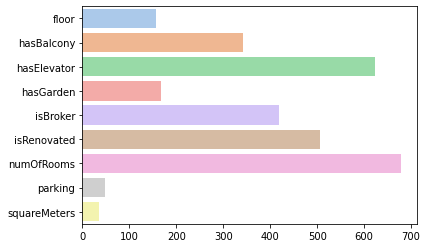

In [ ]:
sns.barplot(x=lr_model.params.values[3:], y=lr_model.params.index[3:], palette='pastel')
plt.show()

All coefficients are positive, which means that when they rise the rent price rises as well. For 2 properties with the same parameters, each additional meter costs 36 NIS a month. In addition, an additional room will cost on average 679 NIS. A balcony raises the price of the apartment by 341 NIS.